# Moving Box - Encoder Decoder

In [320]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [321]:
train_collection = get_processed_moving_box_squares()
train_collection += get_processed_diamond()
train_collection += get_processed_rectangle()
train_collection += get_processed_cirlce()
train_collection = augment_reverse_color(train_collection)
train_collection = center_collections(train_collection)
# total number of images
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

{'images:': 'bigsquare-vertical-4', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-4', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-5', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'bigSquare-diagnal', 'dim': (56, 32, 32)}
{'images:': 'bigsquare-vertical-5', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal', 'dim': (56, 32, 32)}
{'images:': 'diamond', 'dim': (56, 32, 32)}
{'images:': 'big-diamond-vertical', 'dim': (56, 32, 32)}
{'images:': 'diamond-vertical3', 'dim': (56, 32, 32)}
{'images:': 'big-diamond-diagnal1', 'dim': (56, 32, 32)}
{'images:': 'big-diamond-vertical2', 'dim': (56, 32, 32)}
{'images:': 'big-

In [322]:
test_collection = get_collection("data/moving-box/test")
test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
# total number of images
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

{'images:': 'big-diamond', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}

After Augmentation: Test set has 4 collections, 224 images in total


## Sample from Collection

In [323]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [-1.0, 1.0]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


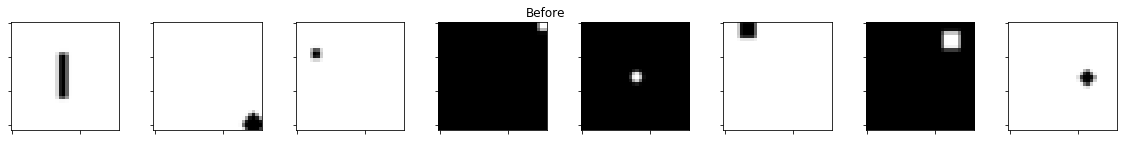

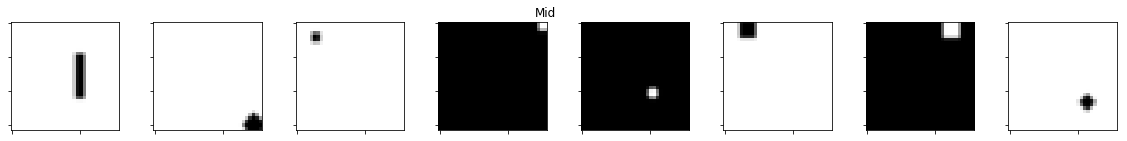

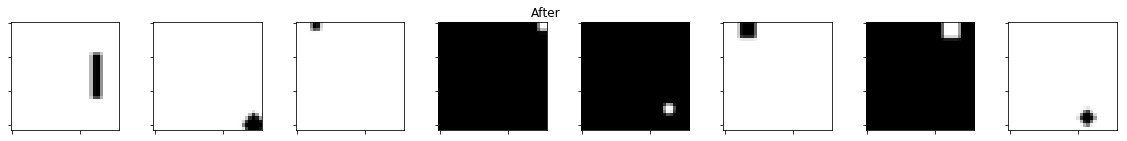

In [324]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 8, gap = 9)

## Sample of Test Data

Range of Image Piece Value: [-1.0, 1.0]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


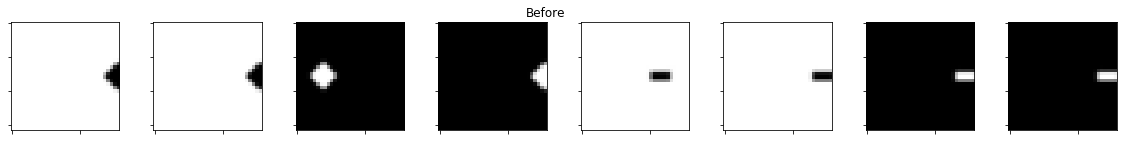

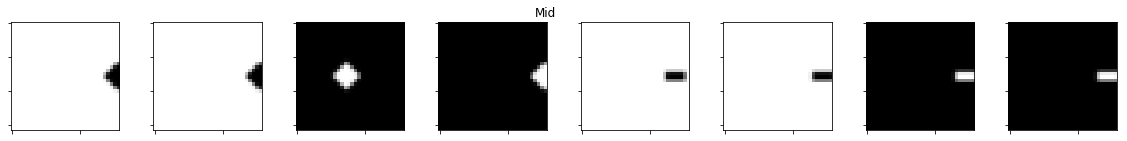

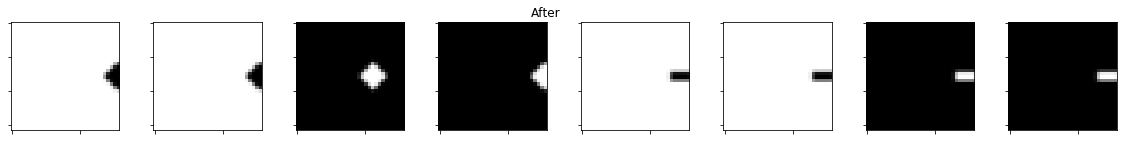

In [325]:
def show_sample_test(batch_size, gap):
    before, after, mid = sample_test(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")

show_sample_test(batch_size=8, gap = 9)

## Target

### Gap: How harsh do you want to train the model?

In [326]:
gap = 1

### Model Capacity

In [387]:
feature_channel = 256

## Param

In [388]:
batch_size = 32

learning_rate = 4e-4

beta = 0.6 # defalut 0.9 for adam
num_iteration = 8000

### Leaky Relu

In [389]:
def leaky_relu(x): return tf.maximum(x, alpha * x)

# Encoder

In [390]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8, 8, feature_channel]
    """
    x = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 16, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    return x

# Decoder

In [391]:
def decode(feature1, feature2, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.concat([feature1, feature2], axis=3)

    x = tf.layers.conv2d(x, filters = 128, kernel_size=5, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Generator

In [392]:
def generate(x1, x2,  is_training=True):
    with tf.variable_scope("generator") as scope:
        feature1, feature2 = encode(x1, is_training), encode(x2, is_training)
        img = decode(feature1, feature2, is_training)
        return img

### Loss

In [393]:
def content_loss(x, gd):
    return tf.norm(x-gd)

### Get a Batch Generation

In [394]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

### Solver

In [395]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [396]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss = sess.run(G_loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [397]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

# alpha   = tf.Variable(0., "alpha") # parameter for leaky relu
G_batch = generate(batch_before, batch_after)


G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [398]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6, num_plot = 6):
    g_losses = []
    for i in range(num_iteration):
        # get a sample
        gap = np.random.choice([1,3,5,7,9])
        real_before, real_after, real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_before, real_after, real_mid = sample_train(num_plot, gap)
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
            
    return g_losses

# Train !

Iteration 0:  G_loss = 716.2121987342834 | Gap = 9


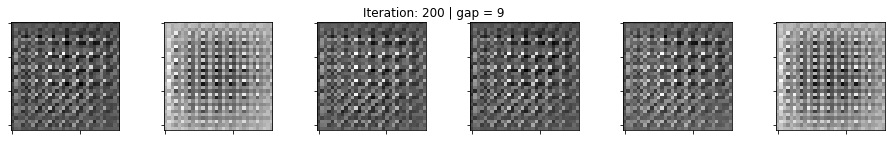

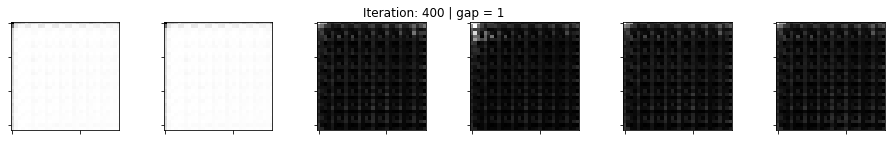

Iteration 400:  G_loss = 156.8308237195015 | Gap = 1


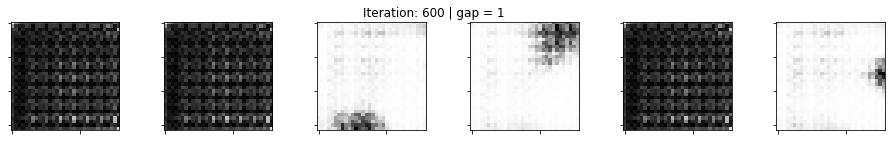

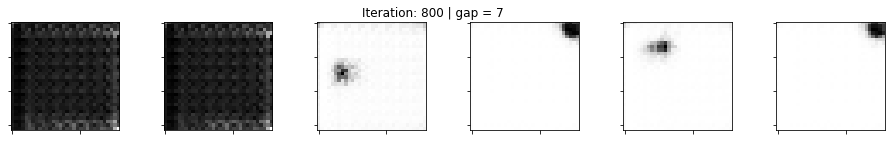

Iteration 800:  G_loss = 83.90550926327705 | Gap = 5


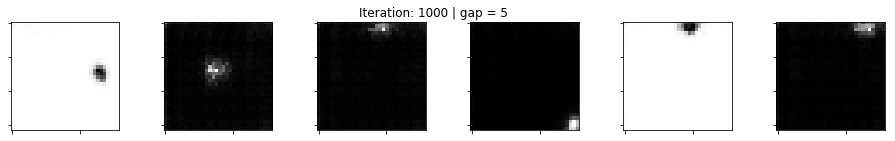

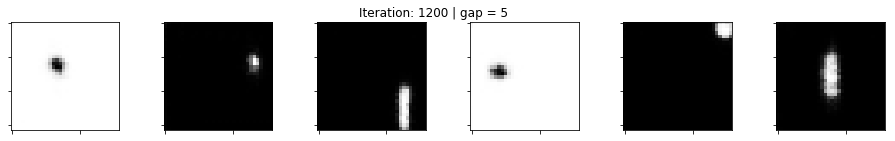

Iteration 1200:  G_loss = 63.10652732849121 | Gap = 7


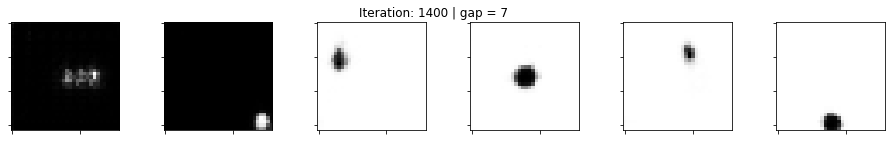

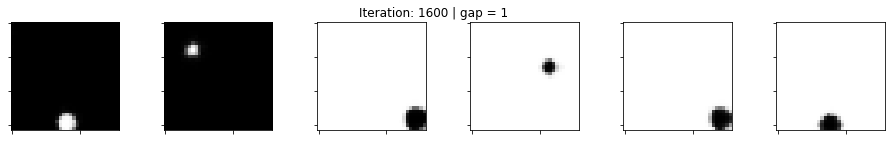

Iteration 1600:  G_loss = 45.75090542435646 | Gap = 7


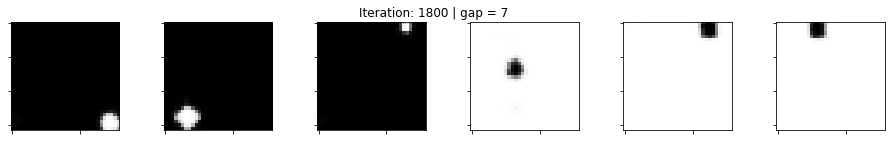

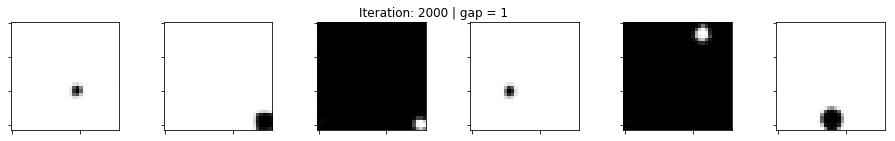

Iteration 2000:  G_loss = 34.66859109699726 | Gap = 7


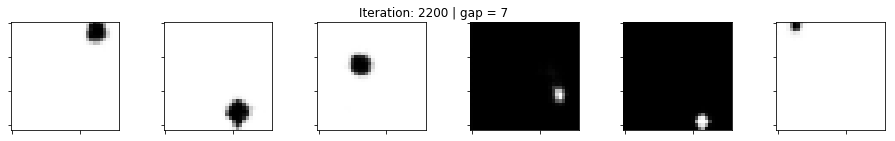

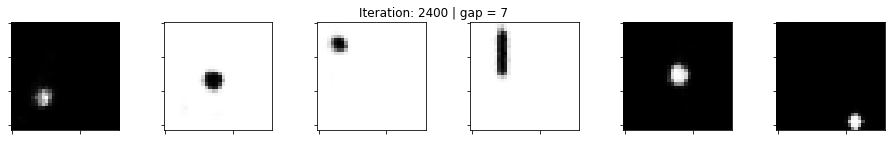

Iteration 2400:  G_loss = 36.32145680487156 | Gap = 7


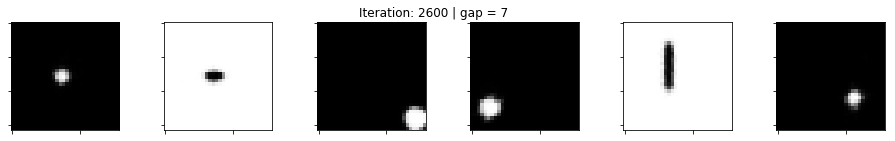

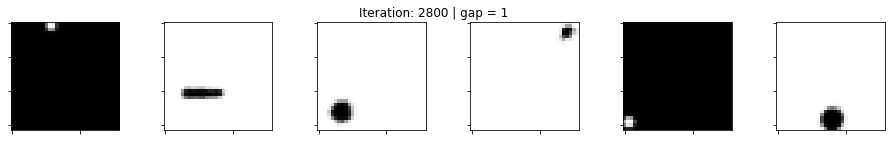

Iteration 2800:  G_loss = 28.734257631003857 | Gap = 5


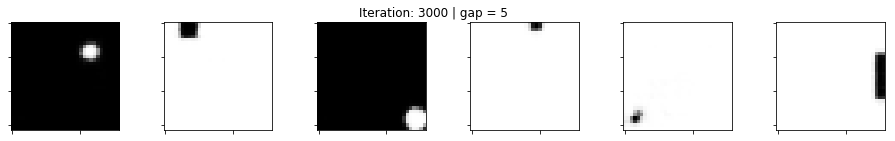

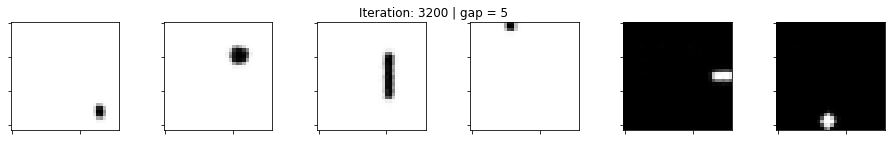

Iteration 3200:  G_loss = 27.516968250274658 | Gap = 1


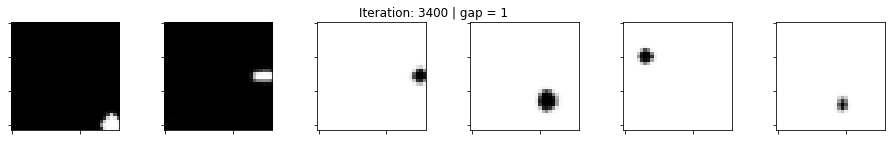

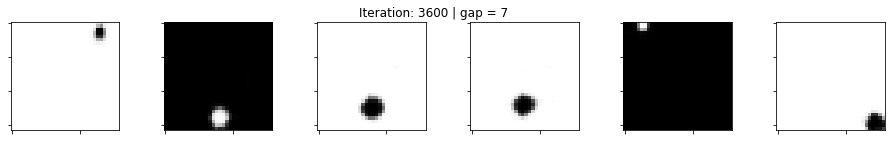

Iteration 3600:  G_loss = 41.602953001856804 | Gap = 9


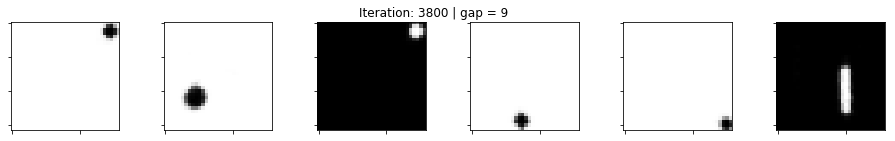

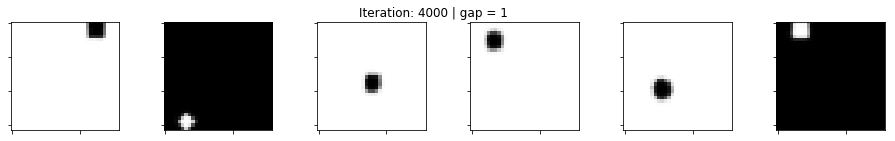

Iteration 4000:  G_loss = 35.88709831237793 | Gap = 7


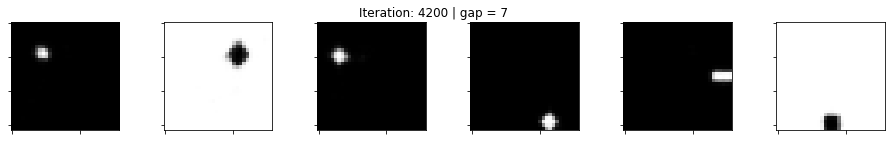

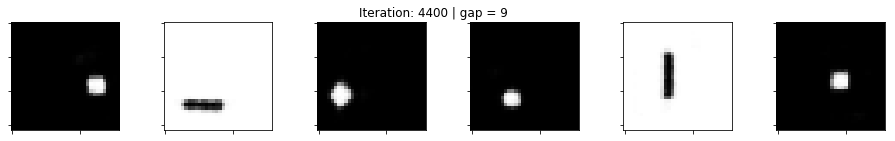

Iteration 4400:  G_loss = 20.786839686334133 | Gap = 1


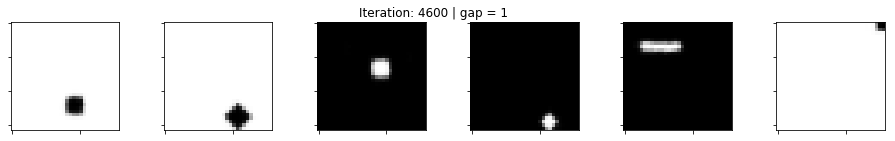

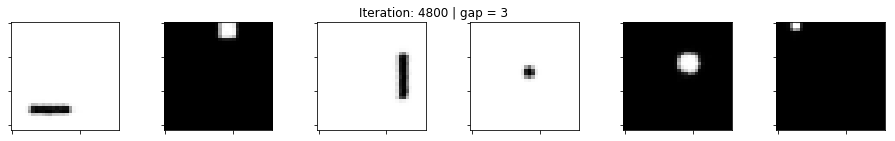

Iteration 4800:  G_loss = 28.331901021301746 | Gap = 7


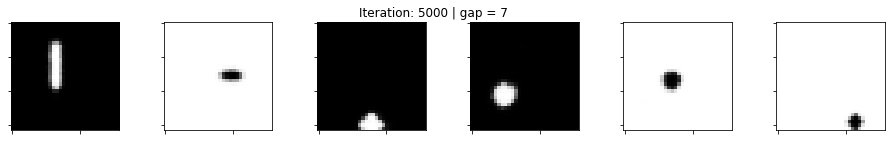

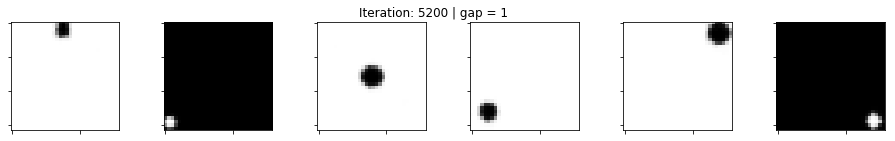

Iteration 5200:  G_loss = 37.09453672170639 | Gap = 1


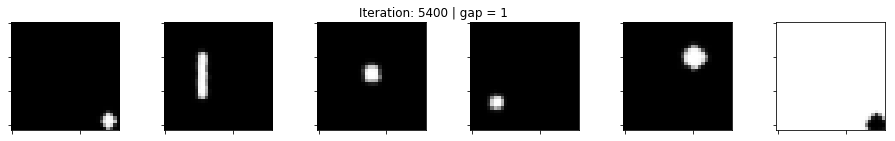

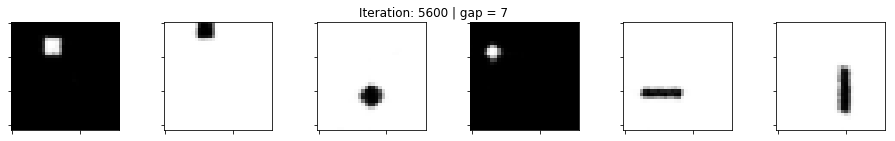

Iteration 5600:  G_loss = 28.337560817599297 | Gap = 7


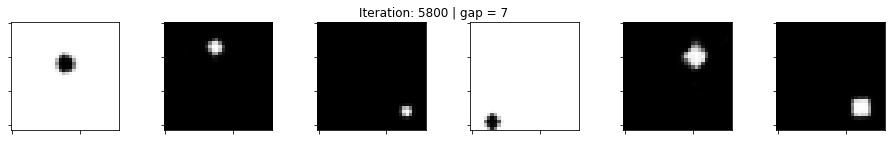

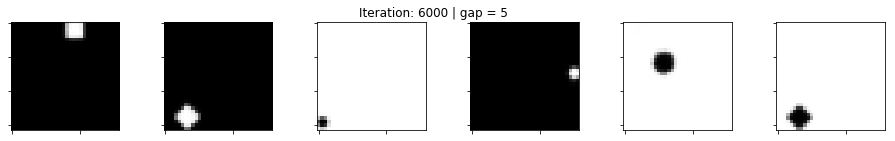

Iteration 6000:  G_loss = 20.723814368247986 | Gap = 5


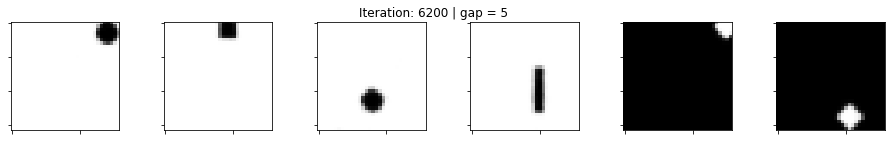

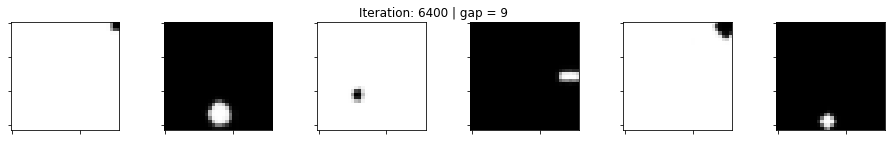

Iteration 6400:  G_loss = 24.372298792004585 | Gap = 9


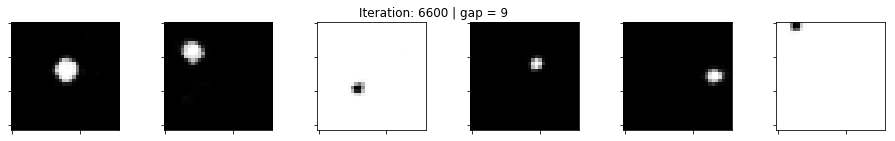

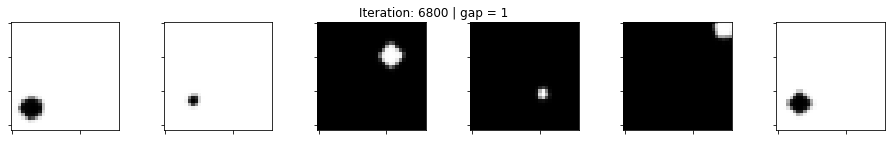

Iteration 6800:  G_loss = 24.442175142467022 | Gap = 1


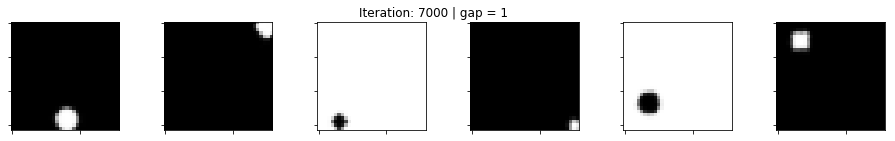

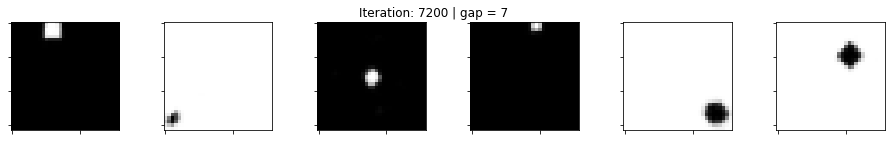

Iteration 7200:  G_loss = 28.427798375487328 | Gap = 1


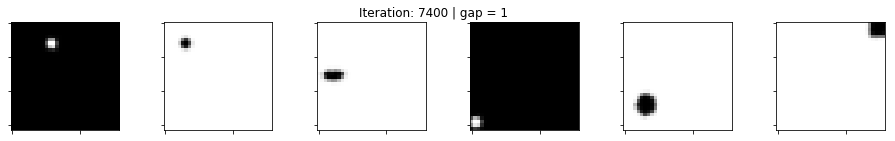

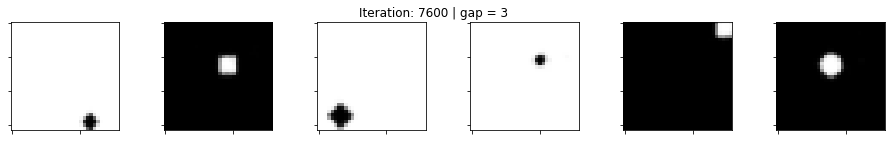

Iteration 7600:  G_loss = 16.161678470671177 | Gap = 7


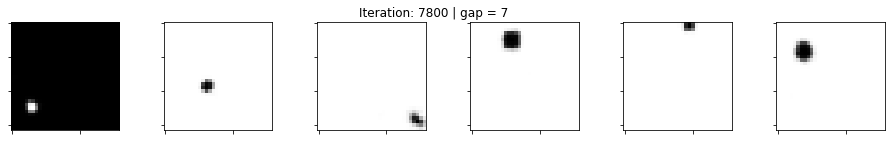

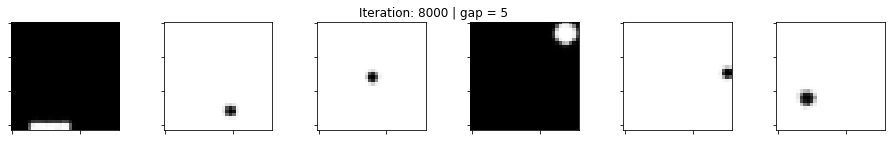

In [399]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 200, show_loss_every = 400, num_plot=6)

## Plot Learning Curve

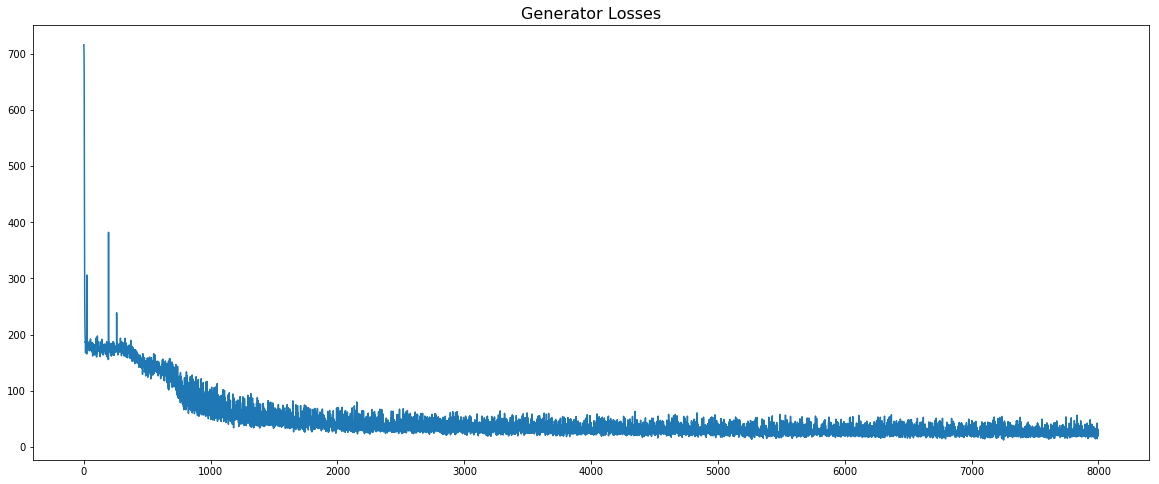

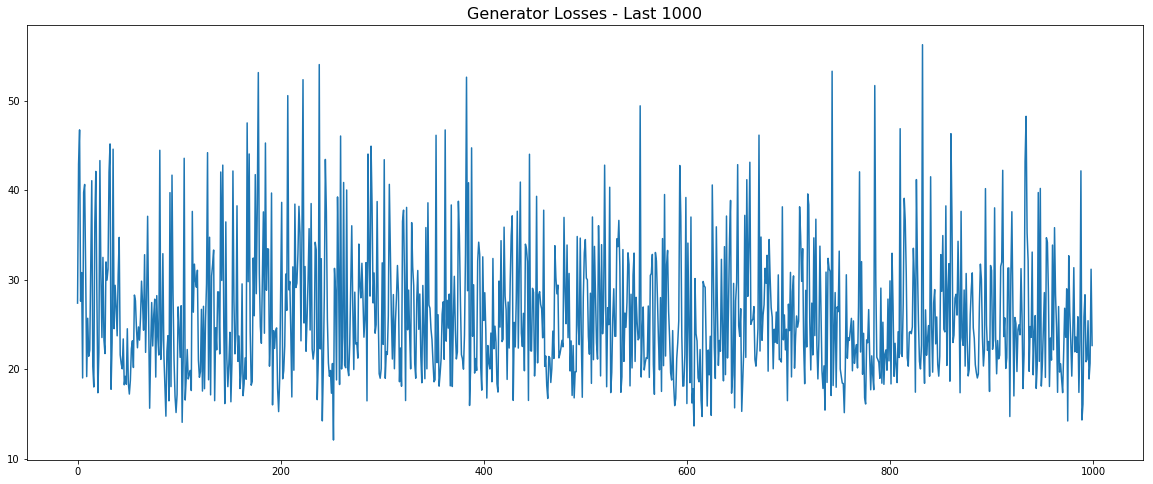

In [400]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [401]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

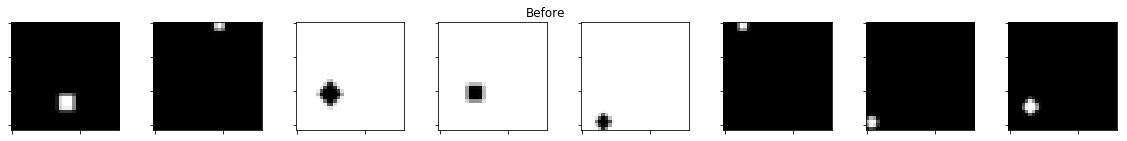

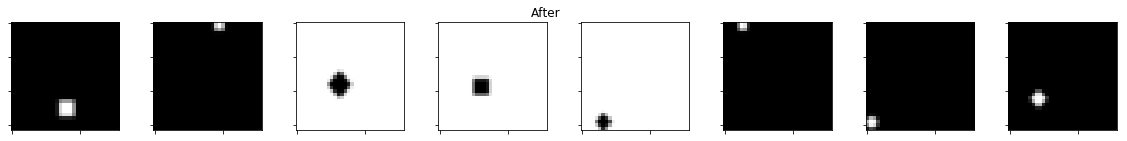

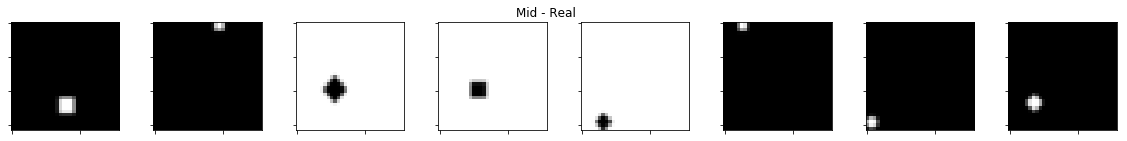

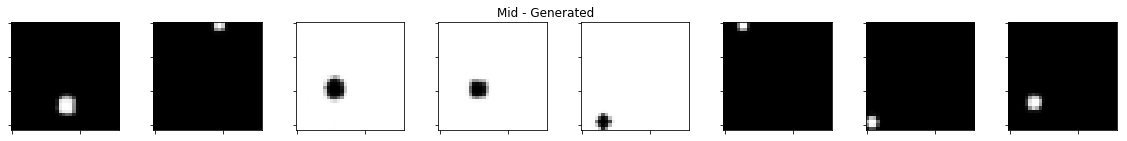

Training Loss = 20.75846090912819


In [402]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 8, gap = gap)

## - Evaluate on Test Data

{'images:': 'big-diamond', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}


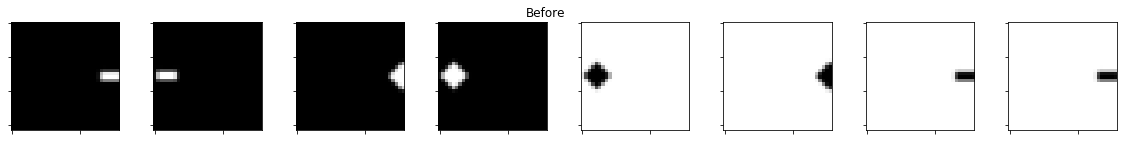

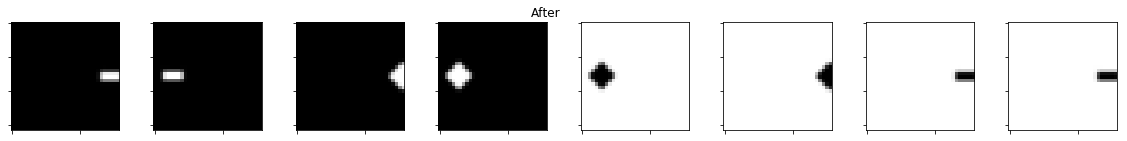

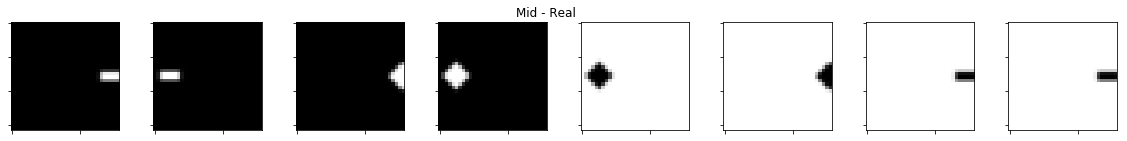

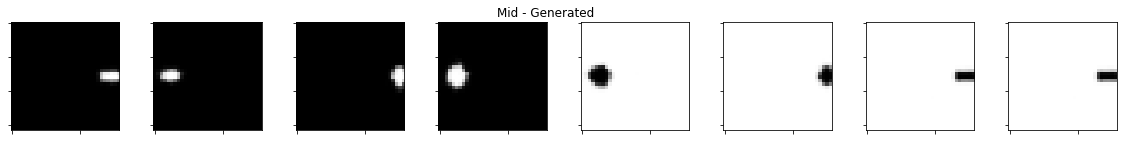

Test Loss = 93.36893185973167


In [403]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_collection = get_collection("data/moving-box/test")
test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
test_loss = eval_test(num_show = 8, gap=1, batch_size = 8)

## How much overfitting?

In [404]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 3.497873530627419
